## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 7: Classification

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC, SVC
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns ; sns.set()

In [2]:
# Make plots look nice

matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.labelpad'] = 8
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


In [4]:
# Show a scatter plot

def show_scatter(training_points, title, filename):
    plt.figure(figsize=(6,6))
    plt.scatter(training_points[:,0], training_points[:,1], s=dot_size)
    plt.title(title)
    plt.xticks([], [])
    plt.yticks([], [])
    file_helper.save_figure(filename)
    plt.show()

In [5]:
# Given the input data, run kMeans for k=[2, 8), and plot them all

def show_clusters(training_points, filename):
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = training_points[:, 0].min() - 1, training_points[:, 0].max() + 1
    y_min, y_max = training_points[:, 1].min() - 1, training_points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    plt.figure(figsize=(9,6))
    for cluster_count in range(2, 8):
        num_clusters = cluster_count
        kMeans = KMeans(n_clusters=num_clusters)
        kMeans.fit(training_points)
        predictions = kMeans.predict(training_points)
        plt.subplot(2, 3, cluster_count-1)
        plt.xticks([], [])
        plt.yticks([], [])
        Z = kMeans.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.3)
        plt.scatter(training_points[:,0], training_points[:,1], s=dot_size/3, c=predictions, cmap='rainbow')    
        plt.title('k='+str(cluster_count))
    file_helper.save_figure(filename)
    plt.show()

In [6]:
# make points drawn from a blob that fits in this box

def make_blob_in_box(xmin, xmax, ymin, ymax, num_pts):
    bxy, bc = make_blobs(n_samples=num_pts, centers=[(0, 0)], n_features=2)
    sx_min = np.min(bxy[:,0])
    sx_max = np.max(bxy[:,0])
    sy_min = np.min(bxy[:,1])
    sy_max = np.max(bxy[:,1])
    normx = [(v[0]-sx_min)/(sx_max-sx_min) for v in bxy]
    normy = [(v[1]-sy_min)/(sy_max-sy_min) for v in bxy]
    sclx = [xmin + ((xmax-xmin) * v) for v in normx]
    scly = [ymin + ((ymax-ymin) * v) for v in normy]
    blobxy = [[sclx[i],scly[i]] for i in range(len(sclx))]
    return blobxy

In [7]:
# make the datasets we'll be using

np.random.seed(42)
num_pts = 200
dot_size = 60
training_points_1 = np.random.uniform(-5, 5, size=(num_pts, 2))

num_pts = 50
bxy1 = make_blob_in_box(-4, -1, -4, 0, num_pts)
bxy2 = make_blob_in_box(-4,  0,  2,  4, num_pts)
bxy3 = make_blob_in_box(0, 1.5, -1.5,  0, num_pts)
bxy4 = make_blob_in_box(2.5, 4, 0, 3, num_pts)
bxy5 = make_blob_in_box(2.5, 4, -4, -3, num_pts)
training_points_2 = np.vstack( [ bxy1, bxy2, bxy3, bxy4, bxy5 ] )
training_points_2_y = [0]*num_pts + [1]*num_pts + [2]*num_pts + [3]*num_pts + [4]*num_pts

cxy1 = make_blob_in_box(-4, -0.5, -4, -0.5, num_pts)
cxy2 = make_blob_in_box(0.5, 4, -4, -1, num_pts)
cxy3 = make_blob_in_box(-1.5, 1.5, .5, 1.5, num_pts)
cxy4 = make_blob_in_box(-3.5, 3.5, 2, 4, num_pts)
training_points_3 = np.vstack( [ cxy1, cxy2, cxy3, cxy4 ] )
training_points_3_y = [0]*num_pts + [1]*num_pts + [2]*num_pts + [3]*num_pts 

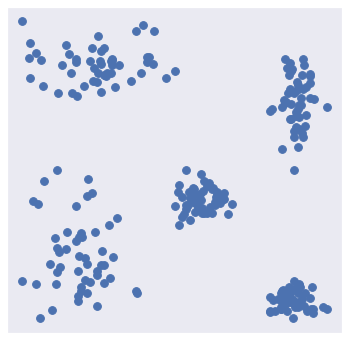

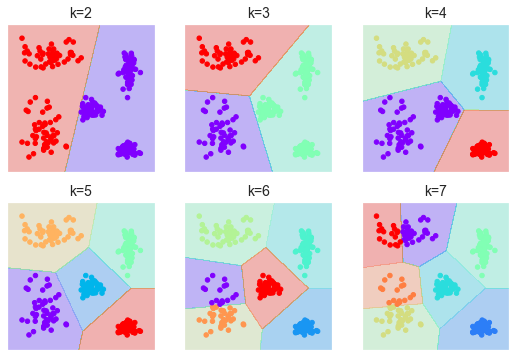

In [8]:
# Show the points, and kMeans clusters for different values of k

show_scatter(training_points_2, '', 'starting-data-2')
show_clusters(training_points_2, 'clusters-2')

In [9]:
# Show clusters at different stages of building

def show_cluster_growth(points, points_y, filename):
    
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    num_clusters = 5
    kMeans = KMeans(n_clusters=num_clusters)
    kMeans.fit(points)
    predictions = kMeans.predict(points)
    Z = kMeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    
    plt.figure(figsize=(10,3))
    plt.subplot(1, 3, 1)
    plt.scatter(points[:,0], points[:,1], c=predictions, cmap='rainbow')
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.subplot(1, 3, 2)
    plt.scatter(points[:,0], points[:,1], c=predictions, cmap='rainbow')
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.subplot(1, 3, 3)
    plt.scatter(points[:,0], points[:,1], c=predictions, cmap='rainbow')


    
    plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.3)
    plt.scatter(points[:,0], points[:,1], s=dot_size/3, c=predictions, cmap='rainbow') 
    plt.xticks([], [])
    plt.yticks([], [])   
        
    file_helper.save_figure(filename)
    plt.show()

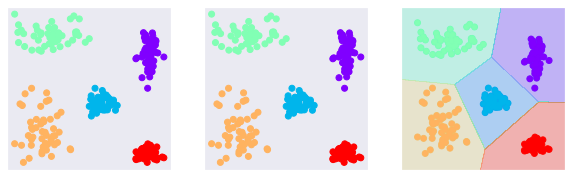

In [10]:
show_cluster_growth(training_points_2, training_points_2_y, 'show-cluster-growth')

In [11]:
# Show examples for one versus rest classification

def draw_setup_one_versus_rest(training_points, training_points_y):
    classifier = OneVsRestClassifier(SVC(probability=True, random_state=42))
    classifier.fit(training_points, training_points_y)

    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = training_points[:, 0].min() - 1, training_points[:, 0].max() + 1
    y_min, y_max = training_points[:, 1].min() - 1, training_points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    predictions = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(9,4))
    plt.subplot(2, 5, 3)
    plt.scatter(training_points[:,0], training_points[:,1], s=dot_size/3, c=training_points_y, cmap='rainbow') 
    plt.xticks([], [])
    plt.yticks([], [])   

    for i in range(5):
        plt.subplot(2, 5, 6+i)
        Z = predictions[:,i]
        this_Z = Z.reshape(xx.shape)
        this_Z = np.reshape(this_Z, xx.shape)
        plt.contourf(xx, yy, this_Z, cmap='rainbow', alpha=0.3)
        plt.scatter(training_points[:,0], training_points[:,1], s=dot_size/3, c=training_points_y, cmap='rainbow') 
        plt.xticks([], [])
        plt.yticks([], [])   
        plt.title('class '+('ABCDE'[i]))

    plt.tight_layout()
    file_helper.save_figure('one-versus-rest-classification-setup')
    plt.show()

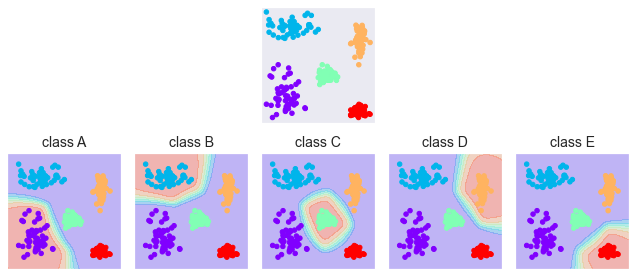

In [12]:
draw_setup_one_versus_rest(training_points_2, training_points_2_y)

In [13]:
# Show classifications for one versus rest

def classify_point_ovr(point, training_points, training_points_y):
    classifier = OneVsRestClassifier(SVC(probability=True, random_state=42))
    classifier.fit(training_points, training_points_y)

    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = training_points[:, 0].min() - 1, training_points[:, 0].max() + 1
    y_min, y_max = training_points[:, 1].min() - 1, training_points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    predictions = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    
    plt.figure(figsize=(10,6)) 

    for i in range(5):
        plt.subplot(3, 5, 6+i)
        #this_Z = [i if z==i else 9 for z in flat_Z]
        this_Z = predictions[:,i]
        this_Z = np.reshape(this_Z, xx.shape)
        plt.contourf(xx, yy, this_Z, cmap='rainbow', alpha=0.3)
        plt.scatter([point[0]],[point[1]], s=dot_size, c='black')
        plt.xticks([], [])
        plt.yticks([], [])   
        plt.title('class '+('ABCDE'[i]))

    file_helper.save_figure('one-versus-rest-point-classification')
    plt.show()

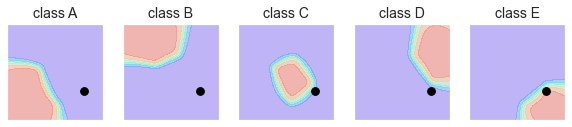

In [14]:
classify_point_ovr([3, -2], training_points_2, training_points_2_y)

In [15]:
# Show several different blobs of points

def show_set_3():
    plt.figure(figsize=(4,4))
    clr0 = '#0A6382'
    clr1 = '#5AB2AD'
    clr2 = '#F0B687'
    clr3 = '#D4766D'
    mymap = LinearSegmentedColormap.from_list("map0123", (clr0, clr1, clr2, clr3), N=4)
    plt.scatter(training_points_3[:,0], training_points_3[:,1], c=training_points_3_y, s=dot_size, cmap=mymap)
    #plt.title('Starting data 3')
    plt.xticks([], [])
    plt.yticks([], [])
    file_helper.save_figure('starting-data-3')
    plt.show()

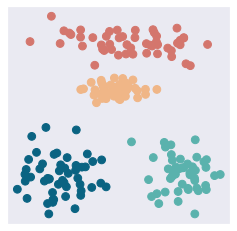

In [16]:
show_set_3()

In [17]:
# Draw the various combinations for one versus one classification

def draw_setup_one_versus_one(training_points, training_points_y, filename, point=None):
    set0 = [training_points_3[i] for i in 
            range(len(training_points_3)) if training_points_3_y[i] == 0]
    set1 = [training_points_3[i] for i in 
            range(len(training_points_3)) if training_points_3_y[i] == 1]
    set2 = [training_points_3[i] for i in 
            range(len(training_points_3)) if training_points_3_y[i] == 2]
    set3 = [training_points_3[i] for i in 
            range(len(training_points_3)) if training_points_3_y[i] == 3]
    
    set01 = set0+set1;
    set01_y = ([0]*len(set0))+([1]*len(set1))
    classifier01 = OneVsOneClassifier(LinearSVC(random_state=42))
    classifier01.fit(set01, set01_y)
    
    set02 = set0+set2;
    set02_y = ([0]*len(set0))+([1]*len(set2))
    classifier02 = OneVsOneClassifier(LinearSVC(random_state=42))
    classifier02.fit(set02, set02_y)
    
    set03 = set0+set3;
    set03_y = ([0]*len(set0))+([1]*len(set3))
    classifier03 = OneVsOneClassifier(LinearSVC(random_state=42))
    classifier03.fit(set03, set03_y)
    
    set12 = set1+set2;
    set12_y = ([0]*len(set1))+([1]*len(set2))
    classifier12 = OneVsOneClassifier(LinearSVC(random_state=42))
    classifier12.fit(set12, set12_y)
    
    set13 = set1+set3;
    set13_y = ([0]*len(set1))+([1]*len(set3))
    classifier13 = OneVsOneClassifier(LinearSVC(random_state=42))
    classifier13.fit(set13, set13_y)
    
    set23 = set2+set3;
    set23_y = ([0]*len(set2))+([1]*len(set3))
    classifier23 = OneVsOneClassifier(LinearSVC(random_state=42))
    classifier23.fit(set23, set23_y)
        
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = training_points[:, 0].min() - 1, training_points[:, 0].max() + 1
    y_min, y_max = training_points[:, 1].min() - 1, training_points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    plt.figure(figsize=(6,6))    
    clr0 = '#0A6382'
    clr1 = '#5AB2AD'
    clr2 = '#F0B687'
    clr3 = '#D4766D'
    
    bg0 = '#3D7082'
    bg1 = '#89B2B0'
    bg2 = '#F0D7C2'
    bg3 = '#D49E98'
    
    plt.subplot(3, 3, 1)
    flat_Z = classifier01.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = flat_Z.reshape(xx.shape)
    this_Z = [0 if z==0 else 9 for z in flat_Z]
    this_Z = np.reshape(this_Z, xx.shape)
    cmap01 = LinearSegmentedColormap.from_list("map01", (bg0, bg1), N=2)
    plt.contourf(xx, yy, this_Z, cmap=cmap01, alpha=0.3)
    all_pts01 = np.array(set0 + set1)
    all_clrs01 = ([clr0]*len(set0))+([clr1]*len(set1))
    plt.xticks([], [])
    plt.yticks([], [])  
    if point:
        plt.scatter([point[0]], [point[1]], s=dot_size, c='black')
    else:
        plt.scatter(all_pts01[:,0], all_pts01[:,1], s=dot_size/3, c=all_clrs01)
    plt.title('Class B')
    
    plt.subplot(3, 3, 2)
    flat_Z = classifier02.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = flat_Z.reshape(xx.shape)
    this_Z = [0 if z==0 else 9 for z in flat_Z]
    this_Z = np.reshape(this_Z, xx.shape)
    cmap02 = LinearSegmentedColormap.from_list("map02", (bg0, bg2), N=2)
    plt.contourf(xx, yy, this_Z, cmap=cmap02, alpha=0.3)
    all_pts02 = np.array(set0 + set2)
    all_clrs02 = ([clr0]*len(set0))+([clr2]*len(set2))
    plt.xticks([], [])
    plt.yticks([], [])   
    if point:
        plt.scatter([point[0]], [point[1]], s=dot_size, c='black')
    else:
        plt.scatter(all_pts02[:,0], all_pts02[:,1], s=dot_size/3, c=all_clrs02)
    plt.title('Class C')
    
    plt.subplot(3, 3, 3)
    flat_Z = classifier03.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = flat_Z.reshape(xx.shape)
    this_Z = [0 if z==0 else 9 for z in flat_Z]
    this_Z = np.reshape(this_Z, xx.shape)
    cmap03 = LinearSegmentedColormap.from_list("map03", (bg0, bg3), N=2)
    plt.contourf(xx, yy, this_Z, cmap=cmap03, alpha=0.3)
    all_pts03 = np.array(set0 + set3)
    all_clrs03 = ([clr0]*len(set0))+([clr3]*len(set3))
    plt.xticks([], [])
    plt.yticks([], [])   
    if point:
        plt.scatter([point[0]], [point[1]], s=dot_size, c='black')
    else:
        plt.scatter(all_pts03[:,0], all_pts03[:,1], s=dot_size/3, c=all_clrs03)
    plt.title('Class D')
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    plt.ylabel("Class A")
    
    plt.subplot(3, 3, 5)
    flat_Z = classifier12.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = flat_Z.reshape(xx.shape)
    this_Z = [0 if z==0 else 9 for z in flat_Z]
    this_Z = np.reshape(this_Z, xx.shape)
    cmap12 = LinearSegmentedColormap.from_list("map12", (bg1, bg2), N=2)
    plt.contourf(xx, yy, this_Z, cmap=cmap12, alpha=0.3)
    all_pts12 = np.array(set1 + set2)
    all_clrs12 = ([clr1]*len(set1))+([clr2]*len(set2))
    plt.xticks([], [])
    plt.yticks([], [])   
    if point:
        plt.scatter([point[0]], [point[1]], s=dot_size, c='black')
    else:
        plt.scatter(all_pts12[:,0], all_pts12[:,1], s=dot_size/3, c=all_clrs12)
    
    plt.subplot(3, 3, 6)
    flat_Z = classifier13.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = flat_Z.reshape(xx.shape)
    this_Z = [0 if z==0 else 9 for z in flat_Z]
    this_Z = np.reshape(this_Z, xx.shape)
    cmap13 = LinearSegmentedColormap.from_list("map13", (bg1, bg3), N=2)
    plt.contourf(xx, yy, this_Z, cmap=cmap13, alpha=0.3)
    all_pts13 = np.array(set1 + set3)
    all_clrs13 = ([clr1]*len(set1))+([clr3]*len(set3))
    plt.xticks([], [])
    plt.yticks([], [])   
    if point:
        plt.scatter([point[0]], [point[1]], s=dot_size, c='black')
    else:
        plt.scatter(all_pts13[:,0], all_pts13[:,1], s=dot_size/3, c=all_clrs13)
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    plt.ylabel("Class B")
    
    plt.subplot(3, 3, 9)
    flat_Z = classifier23.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = flat_Z.reshape(xx.shape)
    this_Z = [0 if z==0 else 9 for z in flat_Z]
    this_Z = np.reshape(this_Z, xx.shape)
    cmap23 = LinearSegmentedColormap.from_list("map01", (bg2, bg3), N=2)
    plt.contourf(xx, yy, this_Z, cmap=cmap23, alpha=0.3)
    all_pts23 = np.array(set2 + set3)
    all_clrs23 = ([clr2]*len(set2))+([clr3]*len(set3))
    plt.xticks([], [])
    plt.yticks([], [])   
    if point:
        plt.scatter([point[0]], [point[1]], s=dot_size, c='black')
    else:
        plt.scatter(all_pts23[:,0], all_pts23[:,1], s=dot_size/3, c=all_clrs23)
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    plt.ylabel("Class C")
    
    plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

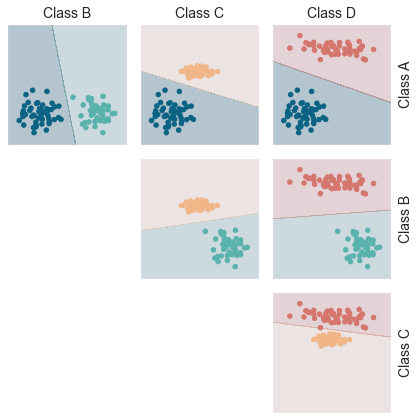

In [18]:
draw_setup_one_versus_one(training_points_3, training_points_3_y, 'one-versus-one-classification-setup')

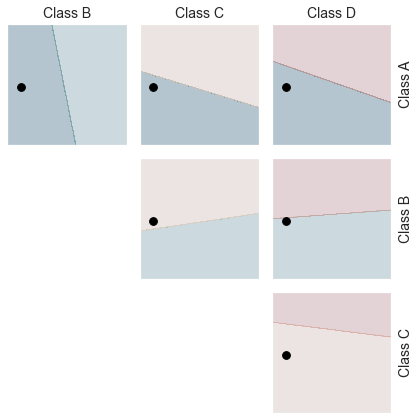

In [19]:
# Show how a particular point lands in the different classification pairs

draw_setup_one_versus_one(training_points_3, training_points_3_y, 
                          'one-versus-one-classification-action', point=[-3.85,-0.2])

In [20]:
# Show how many binary classifiers are needed as a function of number of classes

def plot_binary_classifiers_needed():
    xs = range(3, 100)
    ys = [math.factorial(n)/(2*math.factorial(n-2)) for n in xs]
    plt.figure(figsize=(6,4))
    plt.plot(xs, ys, lw=2)
    plt.ylim(-40, 40+max(ys))
    plt.yticks([0,1000,2000,3000,4000,5000],[0,1000,2000,3000,4000,5000])
    plt.title("Number of Binary Classifiers Needed by Number of Classes")
    plt.xlabel("Number of Classes")
    plt.ylabel("Number of Binary Classifiers")
    file_helper.save_figure('num-binary-classifiers')
    plt.show()

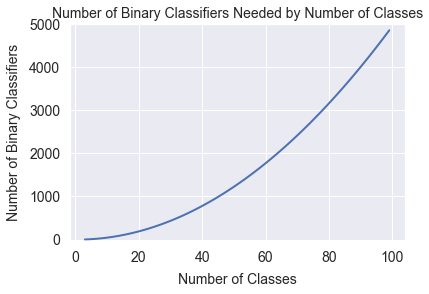

In [21]:
plot_binary_classifiers_needed()

In [22]:
# What's the average distance between uniformly distributed points for a given number of dimensions?

def avg_distance(num_dimensions, num_trials):
    distances = []
    for i in range(num_trials):
        p0 = np.random.uniform(0, 1, num_dimensions)
        p1 = np.random.uniform(0, 1, num_dimensions)
        dd = [(p0[i]-p1[i])**2 for i in range(len(p0))]
        distances.append(math.sqrt(sum(dd)))
    return sum(distances)/len(distances)

In [23]:
# Show the distance for different dimensions

def plot_distance_by_dimension():
    v = [avg_distance(dim, 1000) for dim in range(1,50)]
    fig = plt.figure(figsize=(8,6))
    x = np.arange(1,50)
    plt.scatter(x, v, s=50)
    plt.xlim(0, 50)
    plt.xlabel("Number of dimensions")
    plt.ylabel("Average Distance")
    plt.title("Average point distance by dimension")
    file_helper.save_figure('dim-distances')
    plt.show()

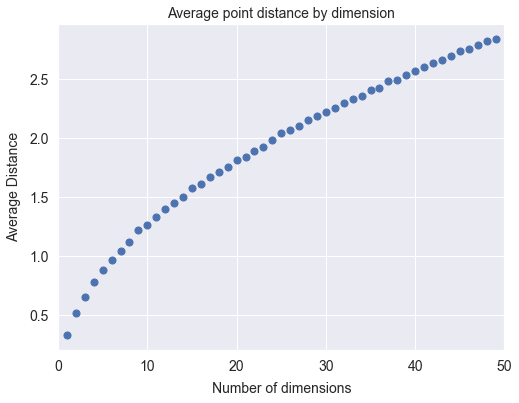

In [24]:
plot_distance_by_dimension()

In [25]:
# What's the density of uniformly distributed points as a function of number of dimensions?

def get_density(num_dimensions, intervals_per_axis):
    number_of_bins = intervals_per_axis ** num_dimensions
    density = 10 / number_of_bins
    return density

In [26]:
# Plot desnity by dimension

def plot_density_by_dimension():
    fig = plt.figure(figsize=(8,6))
    for intervals_per_axis in [2, 3, 4, 5, 6, 10, 20, 100]:
        d = [get_density(dim, intervals_per_axis) for dim in range(1,10)]
        x = np.arange(1,10)
        plt.plot(x, d, label=str(intervals_per_axis), linewidth=2)
    #plt.ylim(0, .6)
    plt.legend(loc='upper right')
    plt.xlabel("Number of dimensions")
    plt.ylabel("Density")
    plt.title("Density of points by dimension and intervals per axis")
    file_helper.save_figure('dim-density')
    plt.show()

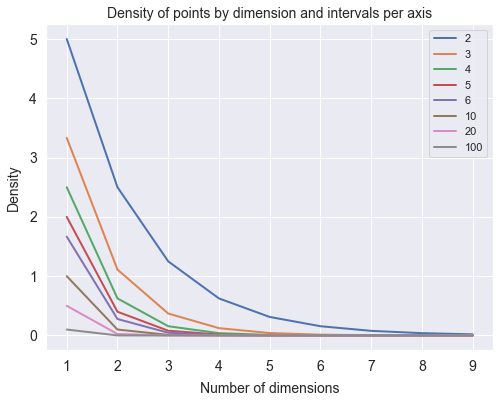

In [27]:
plot_density_by_dimension()

In [28]:
# Get number of points needed for a given density given the slots and dimensions

def get_num_points(desired_density, num_slots, num_dimensions):
    return desired_density * (num_slots ** num_dimensions)

In [29]:
# Get the number of points needed here

def points_per_division(num_dims, slots):
    desired_density = 0.25
    for desired_density in [.1, .3, .5, .7, .9]:
        d = [get_num_points(desired_density, slots, dim) for dim in range(1,num_dims+1)]
        x = np.arange(1,num_dims+1)
        plt.plot(x, d, label=str(desired_density), linewidth=2)
    plt.legend(loc='upper left')
    plt.xlabel("Number of dimensions")
    plt.ylabel("Points needed")
    plt.xticks(range(1, num_dims+1), range(1, num_dims+1))
    #plt.title('Points needed by dimension for given density using '+str(slots)+' dvisions per axis')

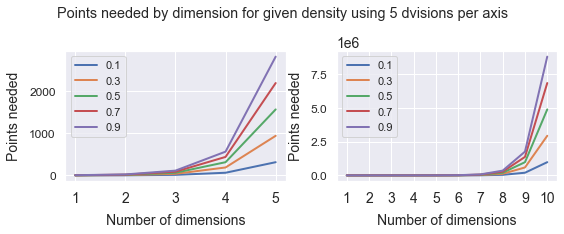

In [30]:
fig = plt.figure(figsize=(8, 3))
slots = 5
plt.subplot(1, 2, 1)
points_per_division(5, slots)
plt.yticks(fontsize=12)
plt.subplot(1, 2, 2)
points_per_division(10, slots)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.suptitle('Points needed by dimension for given density using '+str(slots)+' dvisions per axis', y=1.08)
file_helper.save_figure('points-needed-'+str(slots)+'-slots')
plt.show()

In [31]:
# What's the volume of a hypersphere in different dimensions?
# (uses some fancy math)

from scipy.special import gamma
def hypersphere_volume(dimensions):
    num = (0.5 ** dimensions) * (math.pi ** (dimensions/2))
    den = gamma(1 + (dimensions/2))
    return num/den

In [32]:
# Show the volume for different numbers of dimensions

def plot_hypersphere_volume():
    fig = plt.figure(figsize=(8,6))
    d = np.linspace(1, 11, 10)
    y = [hypersphere_volume(dim) for dim in d]
    plt.scatter(d,y, s=90)
    #plt.plot(d,y, linewidth=2)
    plt.xlabel('Number of dimensions')
    plt.ylabel('Volume of hypersphere')
    plt.xlim(0.5, 11.5)
    plt.xticks(np.arange(1,11))
    file_helper.save_figure('hypersphere-volume')
    plt.show()

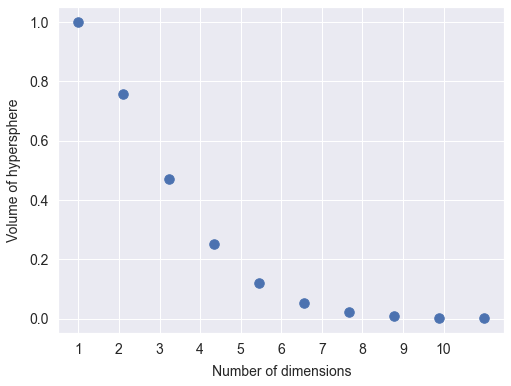

In [33]:
plot_hypersphere_volume()

In [34]:
# What's the radius of a packed orange surrounded by spheres by dimension?

def plot_inner_sphere_radius_by_dimension():
    num_dims = 20
    v = [math.sqrt(dim)-1 for dim in range(2,num_dims)]
    fig = plt.figure(figsize=(8,6))
    x = np.arange(2,num_dims)
    plt.scatter(x, v, s=50)
    plt.xlim(1, num_dims)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Number of dimensions", fontsize=14)
    plt.ylabel("Radius of hyperorange", fontsize=14)
    plt.title("Radius of hyperorange by dimension", fontsize=14)
    file_helper.save_figure('inner-sphere-radius')
    plt.show()

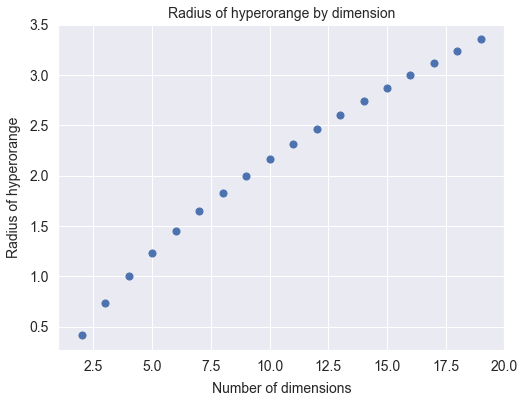

In [35]:
plot_inner_sphere_radius_by_dimension()